# Введение в DS на УБ и МиРА (2022)

## Домашнее задание #4: Линейная регрессия

### Дедлайн: 10 июня 2022 года, 23:59

**Правила игры**

1. Домашнее задание состоит из трёх частей, которые оцениваются в 2 -- 4 -- 4 балла. Все пункты в пределах одной части имеют одинаковый вес.

2. Решения принимаются до **10 июня 2022 года, 23:59 МСК** включительно. Работы, отправленные после дедлайна, **не проверяются**. Дата и время сдачи определяются по последнему запушенному в репозиторий коммиту (можно увидеть на GitHub, наведя мышкой на указатель срока (например, 3 days ago) справа от файлов).

3. Все решения нужно загрузить в личный репозиторий на [GitHub Classroom](https://classroom.github.com/a/vX7_k1kZ).

4. Разрешается использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания. Разрешается использовать любые свободные источники с указанием ссылки на них.

5. Плагиат не допускается. При обнаружении случаев списывания, $0$ за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал. 

Для проверки гипотез используйте ваш любимый уровень значимости! 

---

В этом задании нам предстоит проанализировать набор данных [Weather in Szeged 2006-2016](https://www.kaggle.com/budincsevity/szeged-weather), содержащий информацию о погоде. В качестве зависимой переменной возьмём температуру воздуха в градусах Цельсия (`Temperature (C)`).

Наша цель состоит в том, чтобы построить две линейные регрессионные модели: объясняющую и предиктивную. Объясняющая модель должна быть пригодна для статистической интерпретации зависимостей, то есть показывать, какие факторы влияют на температуру воздуха, каким образом и какое возможное объяснение этого влияния можно привести. Предиктивная модель может быть совершенно ужасной с точки зрения статистики (например, все коэффициенты могут быть не значимы), но она должна давать хорошие прогнозы в соответствии с некоторой метрикой.

Хотя приведённые данные имеют формат временных рядов, мы будем игнорировать это и рассматривать их как обычные кросс-секционные данные (то есть как независимые наблюдения в пространстве).

### Часть 1: Предобработка данных (2 балла)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings  
warnings.filterwarnings('ignore')
from scipy.stats import norm
import time
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.formula.api as smf

**Задание 1.** Загрузите данные из файла `weatherHistory.csv`. Выведите первые 5 строк таблицы.

In [2]:
df = pd.read_csv('weatherHistory.csv')

In [3]:
df.head(10)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
5,2006-04-01 05:00:00.000 +0200,Partly Cloudy,rain,9.222222,7.111111,0.85,13.9587,258.0,14.9569,0.0,1016.66,Partly cloudy throughout the day.
6,2006-04-01 06:00:00.000 +0200,Partly Cloudy,rain,7.733333,5.522222,0.95,12.3648,259.0,9.9820,0.0,1016.72,Partly cloudy throughout the day.
7,2006-04-01 07:00:00.000 +0200,Partly Cloudy,rain,8.772222,6.527778,0.89,14.1519,260.0,9.9820,0.0,1016.84,Partly cloudy throughout the day.
8,2006-04-01 08:00:00.000 +0200,Partly Cloudy,rain,10.822222,10.822222,0.82,11.3183,259.0,9.9820,0.0,1017.37,Partly cloudy throughout the day.
9,2006-04-01 09:00:00.000 +0200,Partly Cloudy,rain,13.772222,13.772222,0.72,12.5258,279.0,9.9820,0.0,1017.22,Partly cloudy throughout the day.


**Задание 2.** Изучите статью о том, что такое [apparent temperature](https://www.kxan.com/weather/difference-between-temperature-and-feels-like-temperature/) (также называемая "feels-like temperature" и "heat index"). Удалите какую-то переменную из набора данных и поясните, почему вы её удалили (помните о том, какая переменная будет целевой). Также удалите переменные:
- `Formatted Date` (потому что договорились, что не обращаем внимания на даты).
- `Daily Summary` (будем использовать просто `Summary`). 

In [4]:
df.drop(columns='Formatted Date', inplace=True)
df.drop(columns='Daily Summary', inplace=True)
# удаляем ее, так как она полностью скоррелированна с целевой, а это проблема для моделей линейной регрессии,
# где незначимые и избыточные переменные не только увеличивают размерность задачи без повышения качества решения,
# но и снижают устойчивость модели.
df.drop(columns='Apparent Temperature (C)', inplace=True)

In [5]:
df.head()

,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,0.0,1015.13
1,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,0.0,1015.63
2,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94
3,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,0.0,1016.41
4,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,0.0,1016.51


**Задание 3.** Есть ли в наборе данных пропущенные значения? Если да, удалите их.

In [6]:
# да, есть в Precip Type
df.isna().sum()

Summary                     0
Precip Type               517
Temperature (C)             0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
dtype: int64

In [7]:
# уря
df = df.dropna()
df.isna().sum()

Summary                   0
Precip Type               0
Temperature (C)           0
Humidity                  0
Wind Speed (km/h)         0
Wind Bearing (degrees)    0
Visibility (km)           0
Loud Cover                0
Pressure (millibars)      0
dtype: int64

**Задание 4.** В данных есть одна числовая переменная, которая не несёт информации для предсказания целевой переменной. Найдите эту переменную, поясните ваш выбор и удалите её. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95936 entries, 0 to 96452
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Summary                 95936 non-null  object 
 1   Precip Type             95936 non-null  object 
 2   Temperature (C)         95936 non-null  float64
 3   Humidity                95936 non-null  float64
 4   Wind Speed (km/h)       95936 non-null  float64
 5   Wind Bearing (degrees)  95936 non-null  float64
 6   Visibility (km)         95936 non-null  float64
 7   Loud Cover              95936 non-null  float64
 8   Pressure (millibars)    95936 non-null  float64
dtypes: float64(7), object(2)
memory usage: 7.3+ MB


In [9]:
df["Loud Cover"].value_counts()

0.0    95936
Name: Loud Cover, dtype: int64

In [10]:
# ну очевидно, что это надо дропать
df.drop(columns='Loud Cover', inplace=True)

In [11]:
df.rename(columns={'Temperature (C)' : 'Temperature', 'Wind Bearing (degrees)' : 'Wind_Bearing',
                   'Pressure (millibars)' : 'Pressure', 'Precip Type' : 'Precip_Type',
                   'Apparent Temperature (C)' : 'Apparent_Temperature', 'Wind Speed (km/h)' : 'Wind_Speed',
                   'Visibility (km)' : 'Visibility', 'Daily Summary' : 'Daily_Summary'}, inplace=True)
# очень важно переименовать, пробелы в название это кринж, некторые методы иногда неработают

In [12]:
df

,Summary,Precip_Type,Temperature,Humidity,Wind_Speed,Wind_Bearing,Visibility,Pressure
0,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,1015.13
1,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,1015.63
2,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,1015.94
3,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,1016.41
4,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,1016.51
...,...,...,...,...,...,...,...,...
96448,Partly Cloudy,rain,26.016667,0.43,10.9963,31.0,16.1000,1014.36
96449,Partly Cloudy,rain,24.583333,0.48,10.0947,20.0,15.5526,1015.16
96450,Partly Cloudy,rain,22.038889,0.56,8.9838,30.0,16.1000,1015.66
96451,Partly Cloudy,rain,21.522222,0.60,10.5294,20.0,16.1000,1015.95


**Задание 5.** Постройте диаграммы рассеяния всех числовых переменных против целевой (для этого используйте какой-то метод из `seaborn`). Есть ли переменные, для которых наблюдается очевидная нелинейная зависимость?

**Подсказка:** это пригодится для частей 2 и 3.

In [13]:
# можно, конечно, и за 1 раз вывести, но так хуже анализируется, поэтому чуть разделим

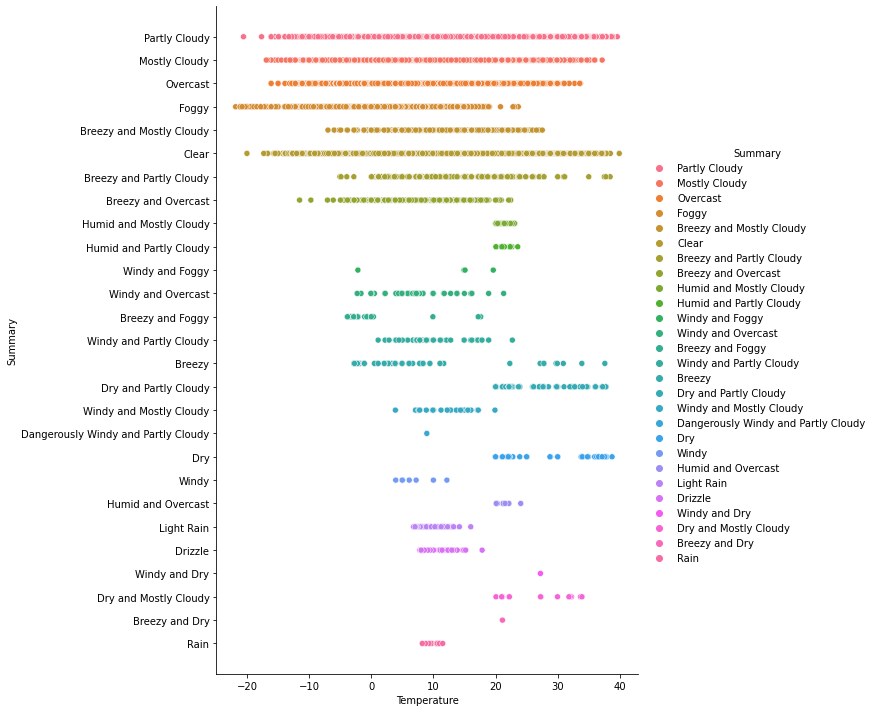

In [14]:
sns.relplot(x="Temperature", y="Summary", data=df,   hue="Summary", height= 10);

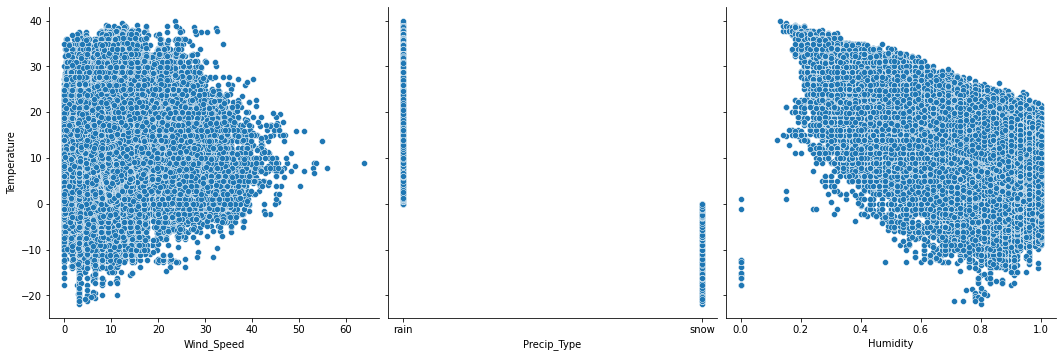

In [15]:
sns.pairplot(
    df, height= 5,
    y_vars=["Temperature"],
    x_vars=['Wind_Speed','Precip_Type','Humidity']
)

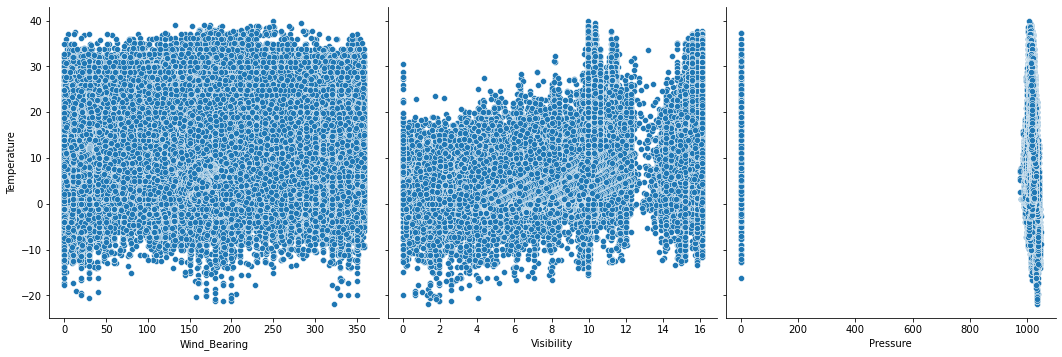

In [16]:
g = sns.pairplot(
    df, height = 5,
    y_vars=["Temperature"],
    x_vars=['Wind_Bearing', 'Visibility',
       'Pressure']
)
g.map_lower(sns.kdeplot, levels=1, color=".2")

In [17]:
# ну да есть нелинейная зависимость с summary, precip type, pressure millibars

**Задание 6.** Преобразуйте категориальные переменные при помощи One Hot Encoding (то есть переведите их в дамми-переменные).

In [18]:
df = pd.get_dummies(df, columns=["Summary"], prefix=["Summary"])
df.head(10)

,Precip_Type,Temperature,Humidity,Wind_Speed,Wind_Bearing,Visibility,Pressure,Summary_Breezy,Summary_Breezy and Dry,Summary_Breezy and Foggy,...,Summary_Mostly Cloudy,Summary_Overcast,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy
0,rain,9.472222,0.89,14.1197,251.0,15.8263,1015.13,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,rain,9.355556,0.86,14.2646,259.0,15.8263,1015.63,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,rain,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,rain,8.288889,0.83,14.1036,269.0,15.8263,1016.41,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,rain,8.755556,0.83,11.0446,259.0,15.8263,1016.51,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,rain,9.222222,0.85,13.9587,258.0,14.9569,1016.66,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,rain,7.733333,0.95,12.3648,259.0,9.9820,1016.72,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,rain,8.772222,0.89,14.1519,260.0,9.9820,1016.84,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,rain,10.822222,0.82,11.3183,259.0,9.9820,1017.37,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,rain,13.772222,0.72,12.5258,279.0,9.9820,1017.22,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [19]:
df = pd.get_dummies(df, columns=["Precip_Type"], prefix=["Precip_Type"])
df.head(10)

,Temperature,Humidity,Wind_Speed,Wind_Bearing,Visibility,Pressure,Summary_Breezy,Summary_Breezy and Dry,Summary_Breezy and Foggy,Summary_Breezy and Mostly Cloudy,...,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy,Precip_Type_rain,Precip_Type_snow
0,9.472222,0.89,14.1197,251.0,15.8263,1015.13,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,9.355556,0.86,14.2646,259.0,15.8263,1015.63,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,8.288889,0.83,14.1036,269.0,15.8263,1016.41,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,8.755556,0.83,11.0446,259.0,15.8263,1016.51,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,9.222222,0.85,13.9587,258.0,14.9569,1016.66,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
6,7.733333,0.95,12.3648,259.0,9.9820,1016.72,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
7,8.772222,0.89,14.1519,260.0,9.9820,1016.84,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
8,10.822222,0.82,11.3183,259.0,9.9820,1017.37,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
9,13.772222,0.72,12.5258,279.0,9.9820,1017.22,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


**Задание 7.** Выведите корреляционную матрицу переменных. Какие переменные лучше всего коррелируют с целевой (назовите три)? 

**Подсказка:** это пригодится для частей 2 и 3.

In [20]:
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr_matrix = df.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
sol.head(10)

Precip_Type_rain       Precip_Type_snow         1.000000
Temperature            Humidity                 0.632148
Visibility             Summary_Foggy            0.597414
Temperature            Precip_Type_snow         0.563503
                       Precip_Type_rain         0.563503
Summary_Mostly Cloudy  Summary_Partly Cloudy    0.449326
Temperature            Visibility               0.393719
Humidity               Visibility               0.370511
Summary_Overcast       Summary_Partly Cloudy    0.319862
Visibility             Precip_Type_rain         0.316483
dtype: float64

**Задание 8.** Разделите данные на регрессоры (`X`) и целевую переменную (`y`). Если всё сделано правильно, то `X` и `y` должны иметь размеры, указанные ниже.

In [21]:
from sklearn.model_selection import train_test_split
X = df.drop('Temperature',axis=1)
y = df['Temperature']

In [22]:
print('X:', X.shape)
print('y:', y.shape)
# X: (95936, 34)
# y: (95936,)

X: (95936, 34)
y: (95936,)


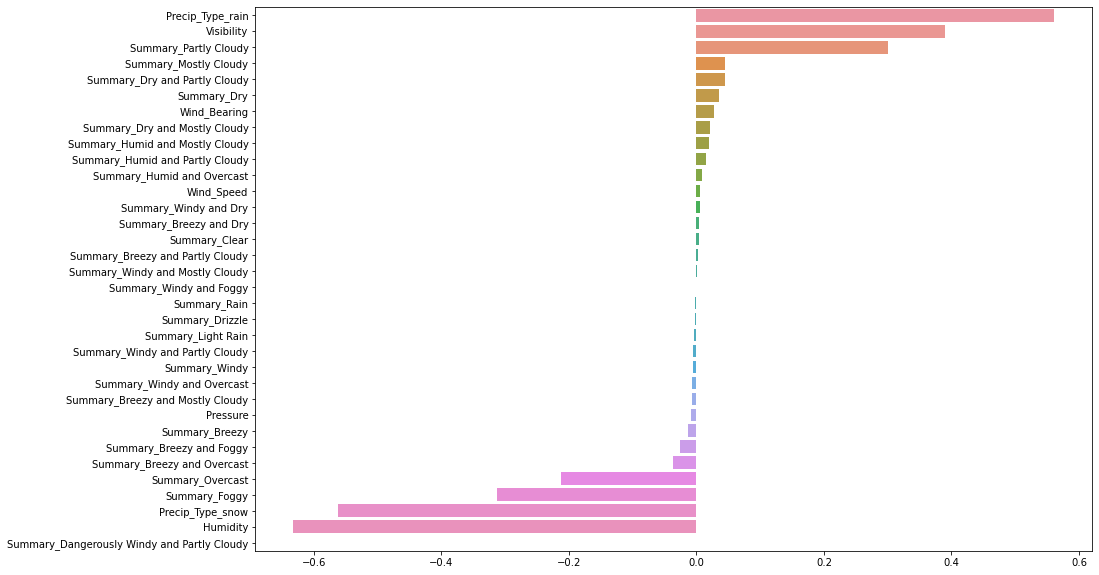

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

num = X_train.select_dtypes(include=np.number)
num_mean = num.mean()
num_features = num.columns

X_train = X_train.fillna(num_mean)
X_test = X_test.fillna(num_mean)

correlations = X_train[num_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

**Задание 8.** Похоже ли распределение целевой переменной на нормальное? Поясните, почему важно, чтобы распределение `y` было похоже на нормальное.

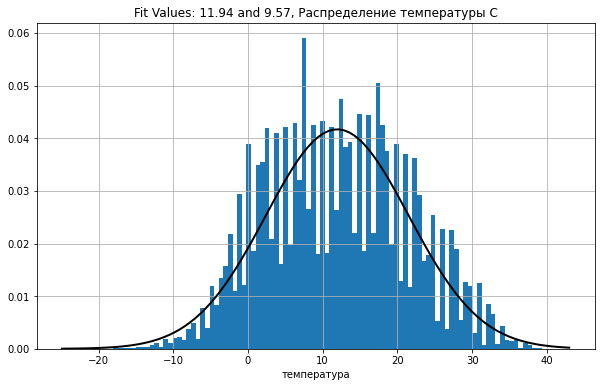

In [24]:
mu, std = norm.fit(y) 

y.hist(bins=100,density=True, figsize = (10,6)) 
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}, Распределение температуры С".format(mu, std)
plt.title(title)
plt.xlabel("температура")
plt.show()

In [25]:
# Оценивая "на глаз" распределени целевой переменной, видим, что оно близко к нормальному. 
# почему оно должно быть нормально распределено?
# Это связано с тем фактом, что все упирается в метрики.
# Например, асимметричное распределение приведет к высоким значениям MSE из-за наблюдений,
# расположенных на другой стороне распределения, в то время как MSE ограничено, если данные преобразуются в 
# нормальное распределение. 
# Случаи, когда модель действительно будет работать лучше с нормально распределенной целью, включают, среди прочего, 
# регрессию гауссовского процесса из-за лежащего в основе предположения о гауссовской случайной величине.
# То есть в итоге равномерное распределение бинов в данных делает модель просто устойчивой к выбросам

### Часть 2: Построение объясняющей модели (4 балла)

**Задание 9.** На основании предыдущего анализа и логических соображений выберите шесть регрессоров (не считая константный), которые будут включены в объясняющую модель. Помните, что когда мы строим объясняющую модель, выбор переменных должнен быть обоснован (не достаточно использовать предыдущий анализ, выбор каждой переменной должен иметь теоретическое или логическое обоснование). В качестве регрессоров можно брать переменные из `X` или преобразования над ними (`Humidity` и `Humidity`$^2$ будем считать разными регрессорами). 

Создайте ячейку Markdown ниже и запишите в неё функциональный вид модели, которую вы будете оценивать. Поясните выбор регрессоров (не нужно углубляться в физику поведения жидкостей и ссылаться на уравнения Навье-Стокса, достаточно понятной научно-популярной интерпретации) и, если используете, выбор нелинейных преобразований над ними.

**Пример ответа:** я строю модель

$$
y_i = \beta_0 + \beta_1 Humidity + \beta_2 Humidity^2 + \beta_3 Humidity^3 + \beta_4 Visibility (km) + \beta_5 Visibility (km) ^ 2 + \beta_6 Summary\_Breezy + \varepsilon_i
$$

Обоснование выбора переменных:
- $Humidity$ – потому что мне кажется, что влажность воздуха влияет на температуру <так-то и так-то>.
- $Humidity^2$ – потому что ...
- ...

### Как видно из матрицы корреляций все признаки коррелирую с целевой, поэтому есть смысл оставить их все, из статьи(ну и выше) видно, что максимальная степень приближающего многочлена - 3

**Задание 10.** Выделите выбранные признаки в переменную `X1`. 

In [26]:
df.head()

,Temperature,Humidity,Wind_Speed,Wind_Bearing,Visibility,Pressure,Summary_Breezy,Summary_Breezy and Dry,Summary_Breezy and Foggy,Summary_Breezy and Mostly Cloudy,...,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy,Precip_Type_rain,Precip_Type_snow
0,9.472222,0.89,14.1197,251.0,15.8263,1015.13,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,9.355556,0.86,14.2646,259.0,15.8263,1015.63,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,8.288889,0.83,14.1036,269.0,15.8263,1016.41,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,8.755556,0.83,11.0446,259.0,15.8263,1016.51,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [31]:
X1 = ["Humidity", "Wind_Speed",
                  "Visibility", "Summary_Rain"]
X = df[X1]
X['Humidity_squared'] = X['Humidity'] * X['Humidity']
X['Humidity_cube'] = X['Humidity_squared'] * X['Humidity']
# X['Wind_Speed_squared'] = X['Wind_Speed'] * X['Wind_Speed']
# вообще хотелось бы попробовать фичу типо логорифм pressure_m так как значение не масштабировано

In [32]:
X

,Humidity,Wind_Speed,Visibility,Summary_Rain,Humidity_squared,Humidity_cube
0,0.89,14.1197,15.8263,0,0.7921,0.704969
1,0.86,14.2646,15.8263,0,0.7396,0.636056
2,0.89,3.9284,14.9569,0,0.7921,0.704969
3,0.83,14.1036,15.8263,0,0.6889,0.571787
4,0.83,11.0446,15.8263,0,0.6889,0.571787
...,...,...,...,...,...,...
96448,0.43,10.9963,16.1000,0,0.1849,0.079507
96449,0.48,10.0947,15.5526,0,0.2304,0.110592
96450,0.56,8.9838,16.1000,0,0.3136,0.175616
96451,0.60,10.5294,16.1000,0,0.3600,0.216000


In [33]:
# Высокая видимость когда нет осадков
# Влажность если на улице жарко
# Скорость ветра напрямую зависит от температуры
# https://www.the-village.me/village/city/gorad-pytanne/270959-weather

**Задание 11.** Оцените модель при помощи МНК (минимзации MSE). Прокомментируйте значимость коэффициентов.

In [34]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [36]:
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

0.47494224689101994


Значение score в LinearRegression равно 0.47 что является неплохой оценкой

**Задание 12.** Поясните, как каждый регрессор влияет на зависимую переменную 
1. математически ("при увеличении $X$ на 1 $Y$ увеличивается на 3") и 
2. содержательно ("$X$ влияет на $Y$ положительно, потому что...", "$X$ не оказывает влияния на $Y$, потому что...").

In [37]:
print(reg.coef_)

[ 8.56353193e+01 -1.71282375e-01  6.22492633e-01  6.66766853e+00
 -2.27966601e+02  1.34997326e+02]


In [38]:
# видно, по коэфам Humidity*8,5 на увеличивается, Wind Speed (km/h)*-1,7 уменьшается на 1.7 и далее по таблице

**Задание 13.** Рассчитайте $R^2$ и MSE на выборке `X1`. Прокомментируйте качество подгонки регрессии.

In [39]:
X_scaled = preprocessing.scale(X)
poly = PolynomialFeatures(3)
X_final = poly.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

In [40]:
model = LinearRegression()
model.fit(X_train, y_train)

# model = linear_model.Ridge(alpha = 0.5)
# model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred

array([ 7.21772961,  7.63851647, 13.03307467, ...,  6.66783783,
       17.29817279,  4.82257993])

In [41]:
len(y_pred),len(y_test)

(28781, 28781)

In [42]:
print("mean-squared-error: %.3f"% mean_squared_error(y_test, y_pred))
print("coeffecients of determination: %.3f"% r2_score(y_test, y_pred))
print("Intercept: ", model.intercept_)
print("Coeffecients: ", len(model.coef_))
print("MAE:", metrics.mean_absolute_error(y_test, y_pred))

mean-squared-error: 44.635
coeffecients of determination: 0.514
Intercept:  11.715213158329705
Coeffecients:  84
MAE: 5.35784331616463


In [43]:
pd.DataFrame({'actual':y_test,
             'prediction':y_pred,
             'diff':(y_test-y_pred)})

,actual,prediction,diff
55053,-0.555556,7.217730,-7.773285
27411,21.111111,7.638516,13.472595
36004,16.600000,13.033075,3.566925
69310,1.600000,12.945429,-11.345429
15875,2.194444,16.674249,-14.479805
...,...,...,...
86522,3.805556,5.176308,-1.370753
96340,17.266667,14.161349,3.105318
95649,7.755556,6.667838,1.087718
89024,28.827778,17.298173,11.529605


### Часть 3: Построение предсказательной модели (4 балла)

В предыдущей части мы хотели объяснить $y$ при помощи каких-то регрессоров, которые мы отбирали из теоретико-логических соображений. Теперь поставим другую задачу: мы не хотим ничего объяснять, а хотим только хорошо предсказывать $y$ по новым наблюдениям. Код ниже поделит выборку (`X`, `y`) на обучающую (`X_train`, `y_train`), на которой будем *оценивать* модель, и *тестовую* (`X_test`, `y_test`), на которой будем предсказывать. 

In [44]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

**Задание 14.** Сохраните в переменные `X_train_1` и `X_test_1` те же признаки из `X_train` и `X_test` соответственно, что и в `X1` (то есть те, которые вы выбрали в задании 9).

Оцените модель на выборке `X_train_1`. Сделайте предсказания на выборках `X_train_1` (то есть обучающей) и `X_test_1` (то есть тестовой). Рассчитайте `MAE` на этих выборках.

In [45]:
X_train_1, X_test_1 = X_train, X_test

In [46]:
len(X_train_1), len(X_test_1)

(67155, 28781)

In [47]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [48]:
y_pred = model.predict(X_test)
y_pred

array([12.00493025, 12.27467962, 15.22141372, ..., 16.62159988,
        5.9153435 , 11.57142404])

In [49]:
len(y_pred), len(y_test)

(28781, 28781)

In [50]:
print(metrics.mean_absolute_error(y_test, y_pred))

5.590179703927121


In [51]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [52]:
y_pred = model.predict(X_test_1)
y_pred

array([12.00493025, 12.27467962, 15.22141372, ..., 16.62159988,
        5.9153435 , 11.57142404])

In [53]:
len(y_pred)

28781

In [54]:
print("Значение MAE = для обьясняющей модели %.4f" % metrics.mean_absolute_error(y_test, y_pred))

Значение MAE = для предсказательной модели 5.5902


**Задание 15.** Теперь сохраните в переменные `X_train_2` и `X_test_2` те же признаки из `X_train` и `X_test` соответственно, что и в `X1` (то есть те, которые вы выбрали в задании 9) и ещё какие-то признаки (количество выберите на ваш вкус, главное, чтобы всего признаков было больше, чем в `X1`). Оцените модель на выборке `X_train_2`. Сделайте предсказания на выборках `X_train_2` (то есть обучающей) и `X_test_2` (то есть тестовой). Рассчитайте `MAE` на этих выборках. Удалось ли повысить качество на обучающей выборке? А на тестовой? Поясните. 

In [55]:
X

,Humidity,Wind_Speed,Visibility,Summary_Rain,Humidity_squared,Humidity_cube
0,0.89,14.1197,15.8263,0,0.7921,0.704969
1,0.86,14.2646,15.8263,0,0.7396,0.636056
2,0.89,3.9284,14.9569,0,0.7921,0.704969
3,0.83,14.1036,15.8263,0,0.6889,0.571787
4,0.83,11.0446,15.8263,0,0.6889,0.571787
...,...,...,...,...,...,...
96448,0.43,10.9963,16.1000,0,0.1849,0.079507
96449,0.48,10.0947,15.5526,0,0.2304,0.110592
96450,0.56,8.9838,16.1000,0,0.3136,0.175616
96451,0.60,10.5294,16.1000,0,0.3600,0.216000


In [57]:
X2 = ["Wind_Bearing","Pressure", "Summary_Breezy"]
X2 = df[X2]
X_2 = pd.concat([X, X2],axis=1)

In [58]:
X_2

,Humidity,Wind_Speed,Visibility,Summary_Rain,Humidity_squared,Humidity_cube,Wind_Bearing,Pressure,Summary_Breezy
0,0.89,14.1197,15.8263,0,0.7921,0.704969,251.0,1015.13,0
1,0.86,14.2646,15.8263,0,0.7396,0.636056,259.0,1015.63,0
2,0.89,3.9284,14.9569,0,0.7921,0.704969,204.0,1015.94,0
3,0.83,14.1036,15.8263,0,0.6889,0.571787,269.0,1016.41,0
4,0.83,11.0446,15.8263,0,0.6889,0.571787,259.0,1016.51,0
...,...,...,...,...,...,...,...,...,...
96448,0.43,10.9963,16.1000,0,0.1849,0.079507,31.0,1014.36,0
96449,0.48,10.0947,15.5526,0,0.2304,0.110592,20.0,1015.16,0
96450,0.56,8.9838,16.1000,0,0.3136,0.175616,30.0,1015.66,0
96451,0.60,10.5294,16.1000,0,0.3600,0.216000,20.0,1015.95,0


In [59]:
X_train_2, X_test_2, y_train, y_test = train_test_split(X_2, y, test_size = 0.3)

In [60]:
mod = LinearRegression()
mod.fit(X_train_2, y_train)
y_pred = mod.predict(X_test_2)

print("Значение MAE = для предсказательной модели %.4f" % metrics.mean_absolute_error(y_test, y_pred))

Значение MAE = для предсказательной модели 5.5777


In [ ]:
# немного удалось улучшить качество, так как больше признаков повлияли на модель

**Задание 16.** Прокомментируйте значимость коэффициентов модели, оценённой на `X_train_2`.

In [66]:
X_train_2

,Humidity,Wind_Speed,Visibility,Summary_Rain,Humidity_squared,Humidity_cube,Wind_Bearing,Pressure,Summary_Breezy
74128,0.67,9.4185,9.9820,0,0.4489,0.300763,38.0,1007.85,0
93273,0.46,4.9105,9.9820,0,0.2116,0.097336,185.0,1014.83,0
68464,0.83,13.7172,15.1823,0,0.6889,0.571787,202.0,1027.67,0
33030,0.92,7.9534,2.8014,0,0.8464,0.778688,159.0,1023.67,0
57416,0.69,5.8282,9.9820,0,0.4761,0.328509,271.0,1012.62,0
...,...,...,...,...,...,...,...,...,...
57633,0.67,11.0446,9.9820,0,0.4489,0.300763,271.0,1014.62,0
10937,0.82,9.8210,6.2951,0,0.6724,0.551368,178.0,1009.64,0
65685,0.88,4.2021,11.2700,0,0.7744,0.681472,275.0,1019.97,0
90307,0.93,9.3219,6.9391,0,0.8649,0.804357,131.0,1011.21,0


In [68]:
model_p = smf.ols(data=df, formula = 'Temperature ~ Humidity + Wind_Speed + Visibility + Summary_Rain + Wind_Bearing + Pressure + Summary_Breezy').fit()
print(model_p.summary())
# https://www.statsmodels.org/devel/example_formulas.html

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                 1.124e+04
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        01:16:57   Log-Likelihood:            -3.2408e+05
No. Observations:               95936   AIC:                         6.482e+05
Df Residuals:                   95928   BIC:                         6.482e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         32.2482      0.241    133.

предиктивная модель значима в целом, судя по p_value

**Задание 17.** Будем называть модель, оценённую на `X_train_1`, **объясняющей**, а на `X_train_2` – **предсказательной**. На основании заданий 14 и 15 сделайте вывод, подходит ли объясняющая модель для предсказаний. На основании задания 16 сделайте вывод, подходит ли предсказательная модель для объяснительной интерпретации. 

Объясняющую модель для предсказания использовать можно. Но качество предскзания  будет ниже,
чем у предиктивной. (Из значений) А пред. для объяснения можно использовуем уже реже. 
Из теории хорошая предиктивная модель является и объяснительной, но зачастую предиктивные модели не могут объяснить, например, дисперсию 
В идеале нужно еще дополнительно сравнивать разные метрики, улучшать\подберать модель, но силы нетю(

## Safe Area

Если хотите, напишите здесь что угодно. Можно вставить картинку.